In [144]:
import pandas as pd
import numpy as np

# 알고리즘 Term-Project : RFM Segmentation

## Data -> RFM Table

In [145]:
e_commerce = pd.read_csv('US E-commerce records.csv', encoding='windows-1252')
e_commerce.head(20)

,Order Date,Row ID,Order ID,Ship Mode,Customer ID,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,01-01-20,849,CA-2017-107503,Standard Class,GA-14725,Consumer,United States,Lorain,Ohio,44052,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",48.896,4,0.2,8.5568
1,01-01-20,4010,CA-2017-144463,Standard Class,SC-20725,Consumer,United States,Los Angeles,California,90036,West,FUR-FU-10001215,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Brentwood Wall ...",474.430,11,0.0,199.2606
2,01-01-20,6683,CA-2017-154466,First Class,DP-13390,Home Office,United States,Franklin,Wisconsin,53132,Central,OFF-BI-10002012,Office Supplies,Binders,Wilson Jones Easy Flow II Sheet Lifters,3.600,2,0.0,1.7280
3,01-01-20,8070,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,454.560,5,0.2,-107.9580
4,01-01-20,8071,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,FUR-FU-10002116,Furniture,Furnishings,"Tenex Carpeted, Granite-Look or Clear Contempo...",141.420,5,0.6,-187.3815
5,01-01-20,8072,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,FUR-CH-10003199,Furniture,Chairs,Office Star - Contemporary Task Swivel Chair,310.744,4,0.3,-26.6352
6,01-01-20,8073,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,OFF-AR-10003158,Office Supplies,Art,Fluorescent Highlighters by Dixon,12.736,4,0.2,2.2288
7,01-01-20,8074,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,OFF-BI-10000301,Office Supplies,Binders,GBC Instant Report Kit,6.470,5,0.8,-9.7050
8,01-01-20,8075,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,OFF-BI-10000343,Office Supplies,Binders,"Pressboard Covers with Storage Hooks, 9 1/2"" x...",13.748,14,0.8,-22.6842
9,01-01-20,8076,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,Central,OFF-AP-10004708,Office Supplies,Appliances,Fellowes Superior 10 Outlet Split Surge Protector,15.224,2,0.8,-38.8212


In [146]:
len(e_commerce['Customer ID'].unique())

693

In [147]:
e_commerce['Order Date'] = pd.to_datetime(e_commerce['Order Date'])

In [148]:
recency = e_commerce.sort_values(by=['Customer ID', 
                                     'Order Date'], ascending=True).groupby('Customer ID')[['Customer ID', 
                                                                                            'Order Date']].tail(1)
recency.set_index('Customer ID', inplace=True)

frequency = e_commerce.groupby('Customer ID')[['Order ID']].count()

monetary = e_commerce.groupby('Customer ID')[['Customer ID', 'Sales']].sum()

In [149]:
recency.head(5)

,Order Date
Customer ID,
AA-10315,2020-06-29
AA-10375,2020-11-12
AA-10480,2020-04-15
AA-10645,2020-05-11
AB-10060,2020-09-16


### RFM Table

In [150]:
RFM_Table = pd.concat([recency, frequency, monetary], axis=1)
RFM_Table.rename(columns={'Order Date' : 'Recency', 'Order ID' : 'Frequency', 'Sales' : 'Monetary'}, inplace=True)
RFM_Table

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,2020-06-29,2,374.480
AA-10375,2020-11-12,5,206.732
AA-10480,2020-04-15,1,15.552
AA-10645,2020-05-11,1,12.960
AB-10060,2020-09-16,8,2936.264
...,...,...,...
XP-21865,2020-11-17,6,449.312
YC-21895,2020-12-26,1,750.680
YS-21880,2020-12-21,7,5340.264


### Recency 전처리 : 시간차로 변환

In [151]:
## 데이터 변환
current_day = pd.to_datetime('20200101') ## 기준 날짜를 2020년 1월 1일 0시 0분으로 잡았다.
time_diff = RFM_Table['Recency'] - current_day ## 최근방문일과 기준 날짜의 시간 차이
time_in_seconds = [x.total_seconds() for x in time_diff] ## 시간 차이를 초단위로 계산
RFM_Table['Recency'] = time_in_seconds ## 변환된 데이터를 다시 삽입한다.

시간차가 클수록 더 최근까지 거래가 있었음을 의미 -> 높은 점수

In [152]:
RFM_Table

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,15552000.0,2,374.480
AA-10375,27302400.0,5,206.732
AA-10480,9072000.0,1,15.552
AA-10645,11318400.0,1,12.960
AB-10060,22377600.0,8,2936.264
...,...,...,...
XP-21865,27734400.0,6,449.312
YC-21895,31104000.0,1,750.680
YS-21880,30672000.0,7,5340.264


## RFM Table -> RFM Score

In [153]:
import copy

RFM_Score = copy.deepcopy(RFM_Table)
RFM_Score

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,15552000.0,2,374.480
AA-10375,27302400.0,5,206.732
AA-10480,9072000.0,1,15.552
AA-10645,11318400.0,1,12.960
AB-10060,22377600.0,8,2936.264
...,...,...,...
XP-21865,27734400.0,6,449.312
YC-21895,31104000.0,1,750.680
YS-21880,30672000.0,7,5340.264


In [154]:
for i in range(len(RFM_Score)):
    r = RFM_Table['Recency'][i]
    if r <= np.quantile(RFM_Table['Recency'], 0.2):
        RFM_Score['Recency'][i] = 1
    elif r <= np.quantile(RFM_Table['Recency'], 0.4):
        RFM_Score['Recency'][i] = 2
    elif r <= np.quantile(RFM_Table['Recency'], 0.6):
        RFM_Score['Recency'][i] = 3
    elif r <= np.quantile(RFM_Table['Recency'], 0.8):
        RFM_Score['Recency'][i] = 4
    else:
        RFM_Score['Recency'][i] = 5
        
    f = RFM_Table['Frequency'][i]
    if f <= np.quantile(RFM_Table['Frequency'], 0.2):
        RFM_Score['Frequency'][i] = 1
    elif f <= np.quantile(RFM_Table['Frequency'], 0.4):
        RFM_Score['Frequency'][i] = 2
    elif f <= np.quantile(RFM_Table['Frequency'], 0.6):
        RFM_Score['Frequency'][i] = 3
    elif f <= np.quantile(RFM_Table['Frequency'], 0.8):
        RFM_Score['Frequency'][i] = 4
    else:
        RFM_Score['Frequency'][i] = 5
        
    m = RFM_Table['Monetary'][i]
    if m <= np.quantile(RFM_Table['Monetary'], 0.2):
        RFM_Score['Monetary'][i] = 1
    elif m <= np.quantile(RFM_Table['Monetary'], 0.4):
        RFM_Score['Monetary'][i] = 2
    elif m <= np.quantile(RFM_Table['Monetary'], 0.6):
        RFM_Score['Monetary'][i] = 3
    elif m <= np.quantile(RFM_Table['Monetary'], 0.8):
        RFM_Score['Monetary'][i] = 4
    else:
        RFM_Score['Monetary'][i] = 5

C:\Users\kms10\AppData\Local\Temp\ipykernel_14320\2193788176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Score['Recency'][i] = 1
C:\Users\kms10\AppData\Local\Temp\ipykernel_14320\2193788176.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Score['Frequency'][i] = 1
C:\Users\kms10\AppData\Local\Temp\ipykernel_14320\2193788176.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Score['Monetary'][i] = 2
C:\Users\km

In [155]:
RFM_Score

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,1.0,1,2.0
AA-10375,4.0,3,2.0
AA-10480,1.0,1,1.0
AA-10645,1.0,1,1.0
AB-10060,2.0,5,5.0
...,...,...,...
XP-21865,4.0,4,3.0
YC-21895,5.0,1,3.0
YS-21880,5.0,4,5.0


## RFM Score -> RFM Segmentation

In [156]:
RFM_Score['Segments'] = ''
RFM_Score

,Recency,Frequency,Monetary,Segments
Customer ID,,,,
AA-10315,1.0,1,2.0,
AA-10375,4.0,3,2.0,
AA-10480,1.0,1,1.0,
AA-10645,1.0,1,1.0,
AB-10060,2.0,5,5.0,
...,...,...,...,...
XP-21865,4.0,4,3.0,
YC-21895,5.0,1,3.0,
YS-21880,5.0,4,5.0,


#### Segment 분할표

|SEGMENT|DESCRIPTION|R|F|M|
|---|---|---|---|---|
|Champions|Bought recently, buy often and spend the most|4 – 5|4 – 5|4 – 5|
|Loyal Customers|Spend good money. Responsive to promotions|2 – 4|3 – 4|4 – 5|
|Potential Loyalist|Recent customers spent good amount, bought more than once|3 – 5|1 – 3|1 – 3|
|New Customers|Bought more recently, but not often|4 – 5|< 2|< 2|
|Promising|Recent shoppers, but haven't spent much|3 – 4|< 2|< 2|
|Need Attention|Above-average recency, frequency & monetary values|3 – 4|3 – 4|3 – 4|
|About To Sleep|Below average recency, frequency & monetary values|2 – 3|< 3|< 3|
|At Risk|Spent big money, purchased often but a long time ago|< 3|2 – 5|2 – 5
|Can't Lose Them|Made big purchases and often, but a long time ago|< 2|4 – 5|4 – 5|
|Hibernating|Low spenders, low frequency, purchased a long time ago|2 – 3|2 – 3|2 – 3|
|Lost|Lowest recency, frequency & monetary scores|< 2|< 2|< 2|

In [157]:
for i in range(len(RFM_Score)):
    R = RFM_Score['Recency'][i]
    F = RFM_Score['Frequency'][i]
    M = RFM_Score['Monetary'][i]
    
    if R >= 4 and F >= 4 and M >= 4:
        RFM_Score['Segments'][i] += 'Champions '
    if (R >= 2 and R <= 4) and (F >= 3 and F <= 4) and M >= 4:
        RFM_Score['Segments'][i] += 'Loyal_Customers '
    if R >= 3 and F <= 3 and M <= 3:
        RFM_Score['Segments'][i] += 'Potential_Loyalist '
    if R >= 4 and F < 2 and M < 2:
        RFM_Score['Segments'][i] += 'New_Customers '
    if (R >= 3 and R <= 4) and F < 2 and M < 2:
        RFM_Score['Segments'][i] += 'Promising '
    if (R >= 3 and R <= 4) and (F >= 3 and F <= 4) and (M >= 3 and M <= 4):
        RFM_Score['Segments'][i] += 'Need_Attention '
    if (R >= 2 and R <= 3) and F < 3 and M < 3:
        RFM_Score['Segments'][i] += 'About_To_Sleep '
    if R < 3 and F >= 2 and M >= 2:
        RFM_Score['Segments'][i] += 'At_Risk '
    if R < 2 and F >= 4 and M >= 4:
        RFM_Score['Segments'][i] += "Can't_Lose_Them"
    if (R >= 2 and R <= 3) and (F >= 2 and F <= 3) and (M >= 2 and M <= 3):
        RFM_Score['Segments'][i] += 'Hibernating'
    if R < 2 and F < 2 and M < 2:
        RFM_Score['Segments'][i] += "Lost"    

C:\Users\kms10\AppData\Local\Temp\ipykernel_14320\2254965427.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Score['Segments'][i] += 'Potential_Loyalist '
C:\Users\kms10\AppData\Local\Temp\ipykernel_14320\2254965427.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Score['Segments'][i] += "Lost"
C:\Users\kms10\AppData\Local\Temp\ipykernel_14320\2254965427.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_Score['S

In [158]:
RFM_Score

,Recency,Frequency,Monetary,Segments
Customer ID,,,,
AA-10315,1.0,1,2.0,
AA-10375,4.0,3,2.0,Potential_Loyalist
AA-10480,1.0,1,1.0,Lost
AA-10645,1.0,1,1.0,Lost
AB-10060,2.0,5,5.0,At_Risk
...,...,...,...,...
XP-21865,4.0,4,3.0,Need_Attention
YC-21895,5.0,1,3.0,Potential_Loyalist
YS-21880,5.0,4,5.0,Champions


In [123]:
champions = RFM_Score[RFM_Score['Segments'].str.contains('Champions')]
loyal_customers = RFM_Score[RFM_Score['Segments'].str.contains('Loyal_Customers')]
potential_loyalist = RFM_Score[RFM_Score['Segments'].str.contains('Potential_Loyalist')]
new_customers = RFM_Score[RFM_Score['Segments'].str.contains('New_Customers')]
promising = RFM_Score[RFM_Score['Segments'].str.contains('Promising')]
need_attention = RFM_Score[RFM_Score['Segments'].str.contains('Need_Attention')]
about_to_sleep = RFM_Score[RFM_Score['Segments'].str.contains('About_To_Sleep')]
at_risk = RFM_Score[RFM_Score['Segments'].str.contains('At_Risk')]
cant_lose_them = RFM_Score[RFM_Score['Segments'].str.contains("Can't_Lose_Them")]
hibernating = RFM_Score[RFM_Score['Segments'].str.contains('Hibernating')]
lost = RFM_Score[RFM_Score['Segments'].str.contains('Lost')]

In [124]:
segmentation = [
    champions.index, loyal_customers.index, potential_loyalist.index,
    new_customers.index, promising.index, need_attention.index,
    about_to_sleep.index, at_risk.index, cant_lose_them.index,
    hibernating.index, lost.index
               ]

## 결과 분석

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
titanic = sns.load_dataset("titanic")    # 붓꽃 데이터
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


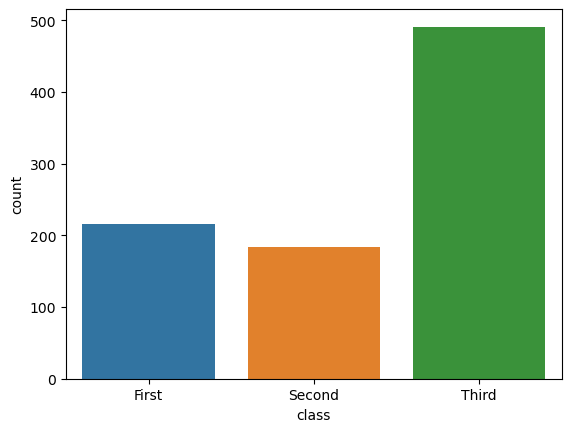

In [170]:
sns.countplot(x="class", data=titanic)
plt.show()

In [193]:
RFM_Score['Segments'].str.contains(' ')

Customer ID
AA-10315    False
AA-10375     True
AA-10480    False
AA-10645    False
AB-10060     True
            ...  
XP-21865     True
YC-21895     True
YS-21880     True
ZC-21910    False
ZD-21925     True
Name: Segments, Length: 693, dtype: bool

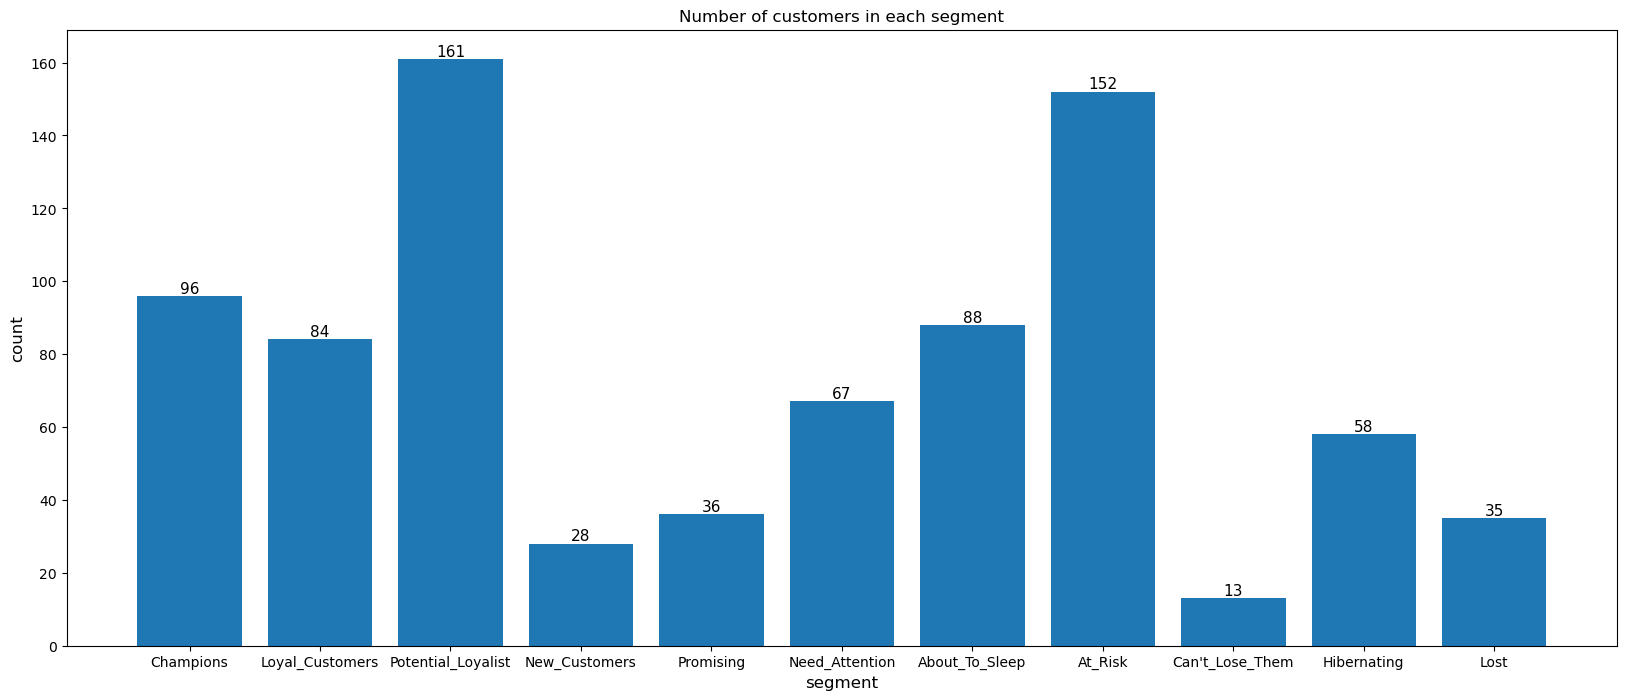

In [209]:
x = np.arange(11)
segments = ['Champions',
'Loyal_Customers',
'Potential_Loyalist',
'New_Customers',
'Promising',
'Need_Attention',
'About_To_Sleep',
'At_Risk',
"Can't_Lose_Them",
'Hibernating',
'Lost']
values = []
for i in range(len(segmentation)):
    values.append(len(segmentation[i]))
plt.figure(figsize=(20,8))
plt.bar(x, values)
# 라벨 설정
plt.title('Number of customers in each segment')
plt.xlabel('segment', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.xticks(x, segments)
for i, v in enumerate(x):
    plt.text(v, values[i], values[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 11, 
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

In [223]:
RFM_Table

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,15552000.0,2,374.480
AA-10375,27302400.0,5,206.732
AA-10480,9072000.0,1,15.552
AA-10645,11318400.0,1,12.960
AB-10060,22377600.0,8,2936.264
...,...,...,...
XP-21865,27734400.0,6,449.312
YC-21895,31104000.0,1,750.680
YS-21880,30672000.0,7,5340.264


In [226]:
import plotly.express as px
fig = px.scatter_ternary(RFM_Score, a="Frequency", b="Recency", c="Monetary")
fig.show()

In [216]:
df

,district,Coderre,Bergeron,Joly,total,winner,result,district_id
0,101-Bois-de-Liesse,2481,1829,3024,7334,Joly,plurality,101
1,102-Cap-Saint-Jacques,2525,1163,2675,6363,Joly,plurality,102
2,11-Sault-au-Récollet,3348,2770,2532,8650,Coderre,plurality,11
3,111-Mile-End,1734,4782,2514,9030,Bergeron,majority,111
4,112-DeLorimier,1770,5933,3044,10747,Bergeron,majority,112
5,113-Jeanne-Mance,1455,3599,2316,7370,Bergeron,plurality,113
6,12-Saint-Sulpice,3252,2521,2543,8316,Coderre,plurality,12
7,121-La Pointe-aux-Prairies,5456,1760,3330,10546,Coderre,majority,121
8,122-Pointe-aux-Trembles,4734,1879,2852,9465,Coderre,majority,122
9,123-Rivière-des-Prairies,5737,958,1656,8351,Coderre,majority,123


In [212]:
RFM_Score

,Recency,Frequency,Monetary,Segments
Customer ID,,,,
AA-10315,1.0,1,2.0,
AA-10375,4.0,3,2.0,Potential_Loyalist
AA-10480,1.0,1,1.0,Lost
AA-10645,1.0,1,1.0,Lost
AB-10060,2.0,5,5.0,At_Risk
...,...,...,...,...
XP-21865,4.0,4,3.0,Need_Attention
YC-21895,5.0,1,3.0,Potential_Loyalist
YS-21880,5.0,4,5.0,Champions
